In [30]:
# pie_clean_distribution.py
# Python 3.10+
import re
import argparse
import random
import numpy as np
import pandas as pd
import soundfile as sf
from collections import defaultdict, Counter
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt  # <-- 추가

In [6]:
from matplotlib import font_manager,rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('C:/Users/user/Desktop/parkinsons/DATA/PD/PD_personPDBS13_trialtrial1.csv')
df

,gyroIndexX,gyroIndexY,gyroIndexZ,gyroThumbX,gyroThumbY,gyroThumbZ,person_id,diagnosis,trial_id,fs
0,-3.398322,-13.586950,2.178971,1.650323,-9.163631,3.667429,PDBS13,PD,trial1,200
1,-1.936859,-12.109719,2.789762,1.749645,-8.674387,3.172980,PDBS13,PD,trial1,200
2,0.773232,-9.934247,3.080615,1.574648,-7.619900,2.586427,PDBS13,PD,trial1,200
3,2.684012,-7.312280,2.387416,1.461136,-4.845936,1.195182,PDBS13,PD,trial1,200
4,2.745497,-4.144070,0.962238,1.106412,-3.373454,0.652257,PDBS13,PD,trial1,200
...,...,...,...,...,...,...,...,...,...,...
4034,0.073243,0.035876,-0.118765,-0.213161,0.041752,-0.036095,PDBS13,PD,trial1,200
4035,0.092162,0.097626,-0.196326,-0.232079,0.051252,0.046313,PDBS13,PD,trial1,200
4036,0.125270,0.206874,-0.264191,-0.236809,0.051252,0.148112,PDBS13,PD,trial1,200
4037,0.163107,0.358872,-0.332057,-0.194242,0.084501,0.220825,PDBS13,PD,trial1,200


In [4]:
df.columns

Index(['gyroIndexX', 'gyroIndexY', 'gyroIndexZ', 'gyroThumbX', 'gyroThumbY',
       'gyroThumbZ', 'person_id', 'diagnosis', 'trial_id', 'fs'],
      dtype='object')

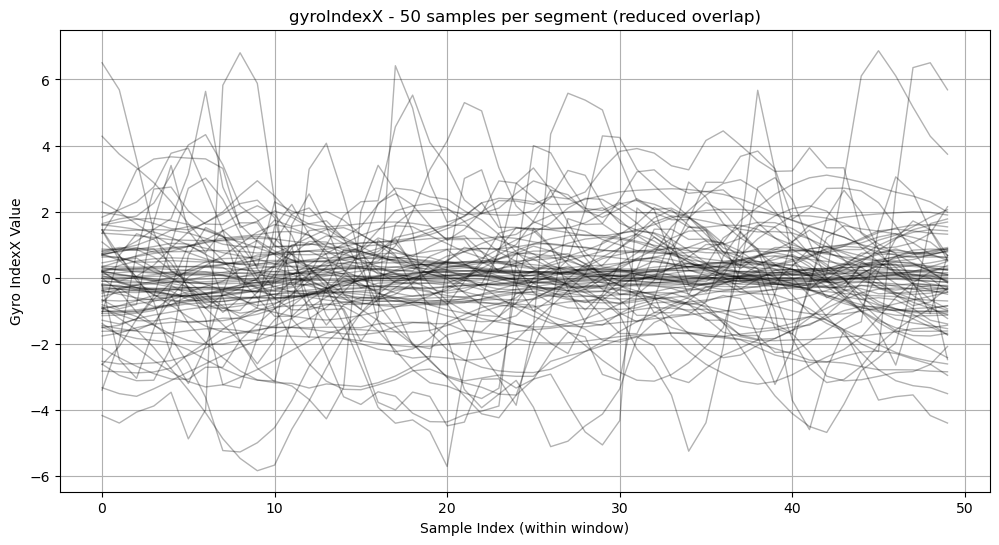

In [27]:
window_size = 50
step = 48  # 겹침 최소화

series = df['gyroIndexX'].values

plt.figure(figsize=(12, 6))
for start in range(0, len(series) - window_size + 1, step):
    seg = series[start:start + window_size]
    plt.plot(np.arange(window_size), seg, color='black', alpha=0.3, linewidth=1)

plt.title("gyroIndexX - 50 samples per segment (reduced overlap)")
plt.xlabel("Sample Index (within window)")
plt.ylabel("Gyro IndexX Value")
plt.grid(True)
plt.show()

[INFO] 그룹별 개수: {'HC': 88, 'MSA': 84, 'PD': 93, 'PSP': 72}


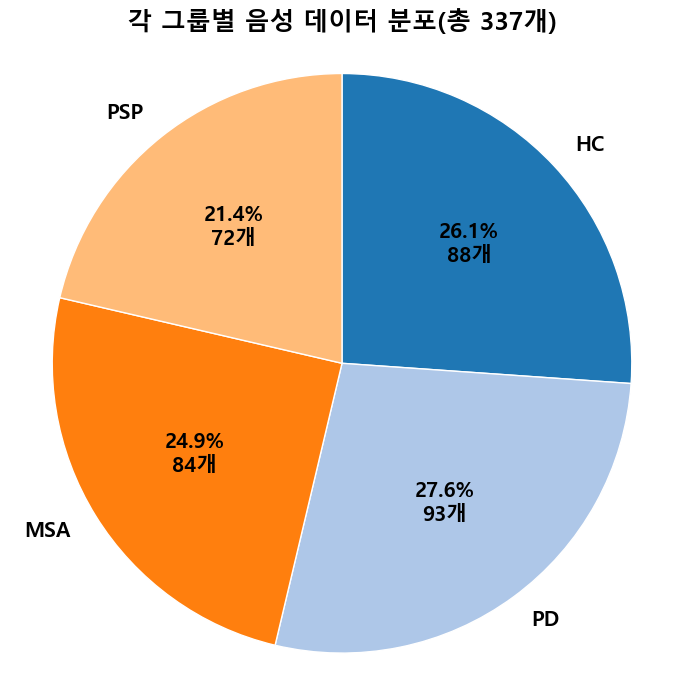

[OK] 저장 완료: clean_group_pie.png


In [ ]:
GROUPS = ('HC', 'PD', 'MSA', 'PSP')
DEFAULT_DATA_DIR = r"C:\Users\user\Desktop\parkinsons\DATA\records"  # <-- raw string

def find_clean_files(data_dir: str) -> Tuple[List[Path], List[str]]:
    root = Path(data_dir)
    if not root.is_dir():
        raise FileNotFoundError(f"폴더를 찾지 못했습니다: {data_dir}")

    rx = re.compile(r"^(HC|PD|MSA|PSP).*?_clean.*\.wav$", re.IGNORECASE)
    paths, labels = [], []

    for p in root.rglob("*.wav"):
        name = p.name
        m = rx.match(name)
        if m:
            lab = m.group(1).upper()
            if lab in GROUPS:
                paths.append(p)
                labels.append(lab)

    if len(paths) == 0:
        raise SystemExit((
            f"[ERROR] 매칭 파일 0개 - data_dir='{data_dir}'\n"
            " - 예시 파일명 : HC1a1_clean.wav / PD3i2_clean.wav\n"
            " - 파일명이 HC|PD|MSA|PSP 로 시작하고 '_clean' 문자열을 포함해야 합니다."
        ))
    return paths, labels


def auto_guess_data_root() -> Optional[str]:
    candidates = [
        "./DATA/records", "./DATA",
        str(Path.cwd() / "DATA" / "records"),
        str(Path.cwd() / "DATA"),
    ]
    for d in candidates:
        dpath = Path(d)
        if dpath.is_dir() and any(dpath.rglob("*_clean*.wav")):
            return str(dpath)
    return None


def autopct_for(values: List[int]):
    total = sum(values)
    def _fmt(pct: float) -> str:
        cnt = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n{cnt}개" if cnt > 0 else ""
    return _fmt


def plot_pie(counter: Dict[str, int], out_path: str = "clean_group_pie.png", title: Optional[str] = None):
    labels = [g for g in GROUPS if counter.get(g, 0) > 0]
    sizes = [counter[g] for g in labels]
    if not sizes:
        raise SystemExit("[ERROR] 집계 결과가 비어 있습니다.")
    
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i % cmap.N) for i in range(len(labels))]
        
    fig, ax = plt.subplots(figsize=(7, 7))
    
    ax.pie(
        sizes,
        labels=labels,
        autopct=autopct_for(sizes),
        startangle=90,
        counterclock=False,
        wedgeprops=dict(edgecolor="white", linewidth=1),
        textprops=dict(fontsize=15, fontweight="bold"),
        colors = colors
    )
    ax.axis("equal")  # 원형 유지
    ax.set_title(title or f"각 그룹별 음성 데이터 분포(총 {sum(sizes)}개)", fontsize=18, pad=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"[OK] 저장 완료: {out_path}")


def main():
    parser = argparse.ArgumentParser(description="그룹별 clean wav 분포 원형 그래프")
    parser.add_argument(
        "--data_dir",
        default=DEFAULT_DATA_DIR,  # <-- raw string 기본값 사용
        help="데이터 루트 폴더 (미지정 시 자동 탐색)"
    )
    parser.add_argument("--out", default="clean_group_pie.png", help="저장 파일명 (png)")
    args, _ = parser.parse_known_args()

    data_dir = args.data_dir or auto_guess_data_root()
    if not data_dir:
        raise SystemExit("[ERROR] 데이터 폴더를 자동으로 찾지 못했습니다. --data_dir 로 경로를 지정하세요.")

    paths, labels = find_clean_files(data_dir)
    counter = Counter(labels)
    print("[INFO] 그룹별 개수:", dict(counter))
    plot_pie(counter, out_path=args.out)


if __name__ == "__main__":
    main()


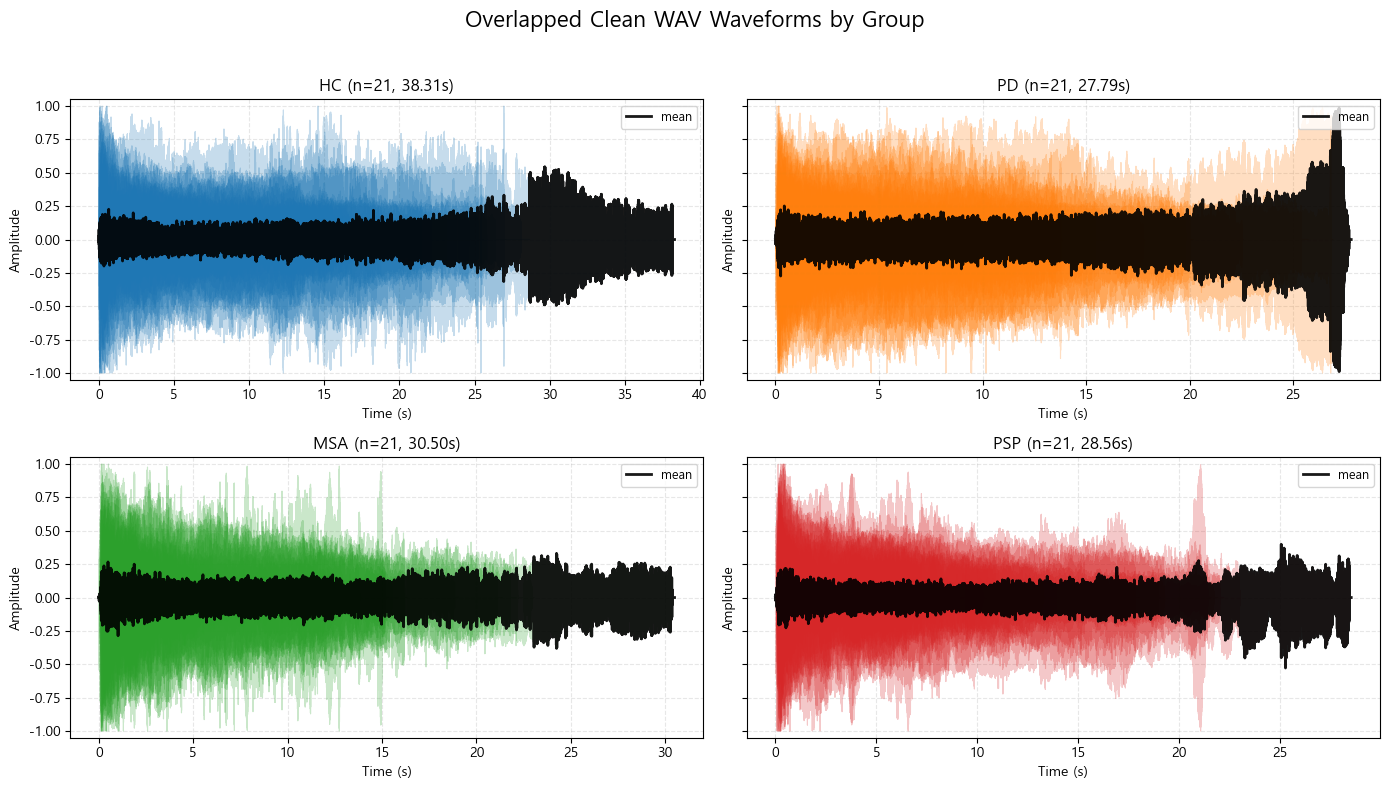

In [23]:
GROUPS = ("HC", "PD", "MSA", "PSP")
DEFAULT_DATA_DIR = r"C:\Users\user\Desktop\parkinsons\DATA\records"  # 환경에 맞게 수정

# ---------------------- 파일 수집 ----------------------
def find_clean_files(data_dir: str) -> Tuple[List[Path], List[str]]:
    root = Path(data_dir)
    if not root.is_dir():
        raise FileNotFoundError(f"폴더를 찾지 못했습니다: {data_dir}")
    rx = re.compile(r"^(HC|PD|MSA|PSP).*?_clean.*\.wav$", re.IGNORECASE)

    paths, labels = [], []
    for p in root.rglob("*.wav"):
        m = rx.match(p.name)
        if m:
            lab = m.group(1).upper()
            if lab in GROUPS:
                paths.append(p)
                labels.append(lab)
    if not paths:
        raise SystemExit(
            f"[ERROR] 매칭 파일 0개 — data_dir='{data_dir}'\n"
            " - 예시: HC1a1_clean.wav / PD3i2_clean.wav\n"
            " - 파일명이 HC|PD|MSA|PSP 로 시작하고 '_clean' 포함 필요"
        )
    return paths, labels

def group_files_map(paths: List[Path], labels: List[str]) -> Dict[str, List[Path]]:
    m: Dict[str, List[Path]] = {g: [] for g in GROUPS}
    for p, lab in zip(paths, labels):
        m[lab].append(p)
    return m

# ---------------------- 오디오 로딩 ----------------------
def read_wav(path: Path) -> Tuple[np.ndarray, int]:
    y, sr = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    # 정규화(겹침 가독성)
    m = np.max(np.abs(y)) + 1e-9
    y = y / m
    return y, sr

def most_common_sr(srs: List[int]) -> int:
    c = Counter(srs).most_common(1)
    return int(c[0][0]) if c else 16000

def resample_linear(y: np.ndarray, sr_from: int, sr_to: int) -> np.ndarray:
    """선형보간 리샘플(길이 비례 유지)."""
    if sr_from == sr_to:
        return y
    # 새 길이는 비율에 비례
    n_new = int(round(len(y) * (sr_to / sr_from)))
    x_old = np.linspace(0.0, 1.0, num=len(y), endpoint=False)
    x_new = np.linspace(0.0, 1.0, num=max(1, n_new), endpoint=False)
    return np.interp(x_new, x_old, y).astype(np.float32)

# ---------------------- 색상 ----------------------
def group_color(group: str):
    cmap = plt.get_cmap("tab20")
    base_idx = {"HC": 0, "PD": 2, "MSA": 4, "PSP": 6}[group.upper()]
    return cmap(base_idx)

# ---------------------- 플로팅 ----------------------
def overlay_for_group(ax, files: List[Path], group: str, n: int, seconds: Optional[float],
                      alpha: float = 0.25, lw: float = 0.8, show_mean: bool = True, seed: Optional[int] = 42):
    """
    seconds > 0  : 앞에서부터 해당 길이만 사용 (부족분 NaN 패딩)
    seconds <= 0 : 각 파일 전체 길이 사용, 가장 긴 길이에 맞춰 NaN 패딩
    """
    if not files:
        ax.set_visible(False)
        return

    rng = random.Random(seed)
    if len(files) > n:
        files = rng.sample(files, n)
    else:
        n = len(files)

    # 로드 + 리샘플(그룹 내 최빈 SR로 통일)
    waves_rs, srs = [], []
    for p in files:
        y, sr = read_wav(p)
        waves_rs.append((y, sr))
        srs.append(sr)
    sr_target = most_common_sr(srs)

    waves_rs = [resample_linear(y, sr_from=sr, sr_to=sr_target) for (y, sr) in waves_rs]
    lengths = [len(y) for y in waves_rs]

    if seconds is not None and seconds > 0:
        # 고정 시간으로 통일
        n_samples = max(1, int(round(sr_target * seconds)))
    else:
        # 전체 길이: 가장 긴 파형 길이에 맞춤
        n_samples = max(lengths)

    # NaN 패딩으로 길이 맞추기(그려지지 않는 구간은 공백)
    proc = []
    for y in waves_rs:
        if len(y) >= n_samples:
            proc.append(y[:n_samples])
        else:
            pad = np.full(n_samples - len(y), np.nan, dtype=np.float32)
            proc.append(np.concatenate([y, pad], axis=0))

    t = np.arange(n_samples) / sr_target
    color = group_color(group)

    for y in proc:
        ax.plot(t, y, color=color, alpha=alpha, linewidth=lw)

    if show_mean:
        # NaN 무시 평균
        stack = np.vstack([y for y in proc])  # (n, T)
        mean_wave = np.nanmean(stack, axis=0)
        ax.plot(t, mean_wave, color="black", linewidth=2.0, alpha=0.9, label="mean")

    dur_sec = n_samples / sr_target
    ax.set_title(f"{group} (n={n}, {dur_sec:.2f}s)", fontsize=12)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_ylim(-1.05, 1.05)
    ax.grid(True, linestyle="--", alpha=0.3)
    if show_mean:
        ax.legend(loc="upper right", fontsize=9)

def plot_all_groups_grid(data_dir: str,
                         n_per_group: int = 21,
                         seconds: float = 0.0,  # 기본: 전체 길이
                         out_path: Optional[str] = "overlay_all_groups.png",
                         dpi: int = 300,
                         seed: int = 42):
    paths, labels = find_clean_files(data_dir)
    gmap = group_files_map(paths, labels)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False, sharey=True)
    axes = axes.ravel()

    for i, g in enumerate(GROUPS):
        overlay_for_group(
            axes[i],
            gmap.get(g, []),
            group=g,
            n=n_per_group,
            seconds=seconds,   # 0이므로 전체 길이
            alpha=0.25,
            lw=0.8,
            show_mean=True,
            seed=seed
        )

    fig.suptitle("Overlapped Clean WAV Waveforms by Group", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()

# ---------------------- CLI ----------------------
def main():
    ap = argparse.ArgumentParser(description="모든 그룹 파형을 한 번에 겹쳐 그리기 (2x2 서브플롯)")
    ap.add_argument("--data_dir", default=DEFAULT_DATA_DIR, help="데이터 루트 폴더")
    ap.add_argument("--n_per_group", type=int, default=21, help="그룹당 겹칠 파일 개수")
    ap.add_argument("--seconds", type=float, default=0.0,
                    help="앞에서부터 사용할 초(<=0이면 전체 길이 사용, NaN 패딩)")
    ap.add_argument("--out", default="overlay_all_groups.png", help="결과 이미지 저장 경로")
    ap.add_argument("--dpi", type=int, default=300, help="저장 DPI")
    ap.add_argument("--seed", type=int, default=42, help="무작위 선택 시 시드")
    args, _ = ap.parse_known_args()

    plot_all_groups_grid(
        data_dir=args.data_dir,
        n_per_group=args.n_per_group,
        seconds=args.seconds,
        out_path=args.out,
        dpi=args.dpi,
        seed=args.seed
    )

if __name__ == "__main__":
    main()

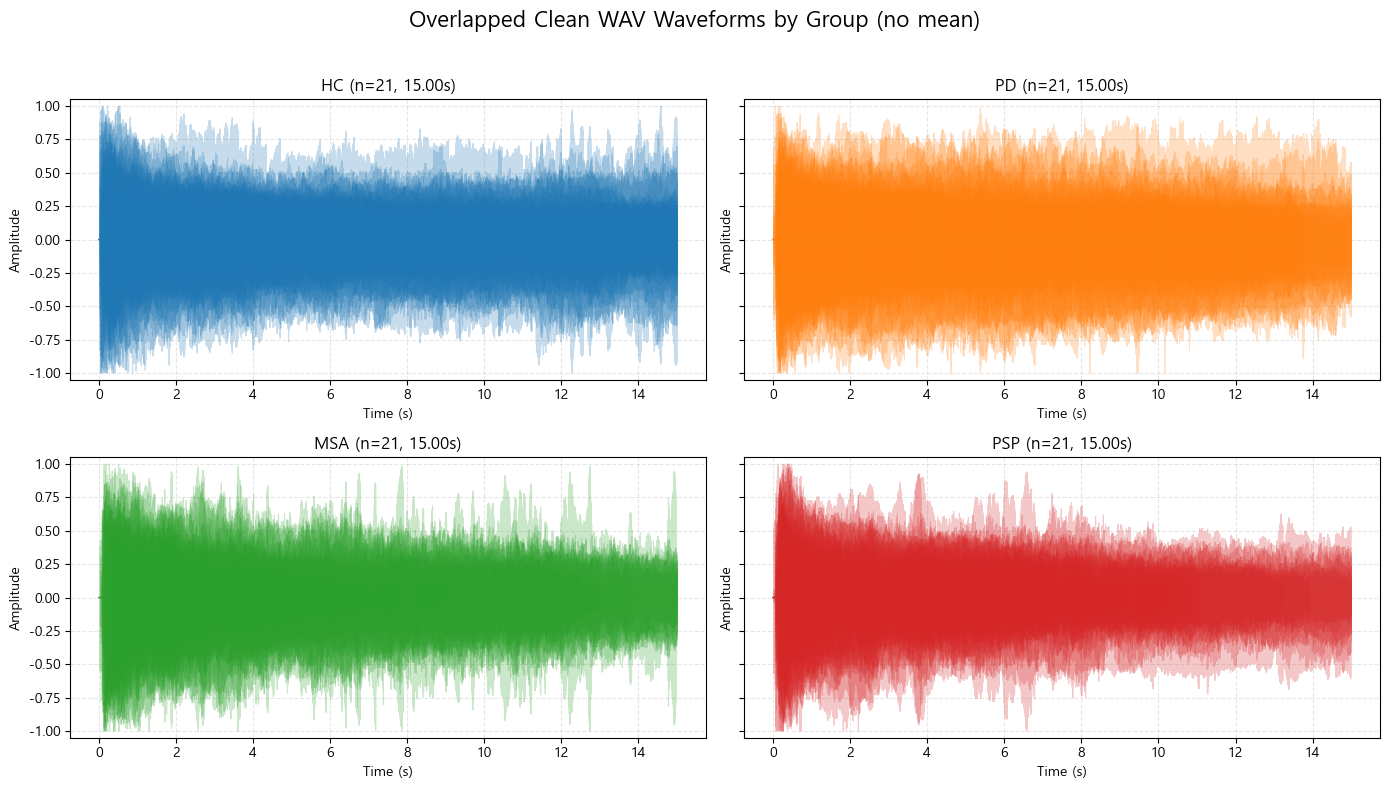

In [27]:

GROUPS = ("HC", "PD", "MSA", "PSP")
DEFAULT_DATA_DIR = r"C:\Users\user\Desktop\parkinsons\DATA\records"  # 필요시 수정

# ---------------------- 파일 수집 ----------------------
def find_clean_files(data_dir: str) -> Tuple[List[Path], List[str]]:
    root = Path(data_dir)
    if not root.is_dir():
        raise FileNotFoundError(f"폴더를 찾지 못했습니다: {data_dir}")
    rx = re.compile(r"^(HC|PD|MSA|PSP).*?_clean.*\.wav$", re.IGNORECASE)

    paths, labels = [], []
    for p in root.rglob("*.wav"):
        m = rx.match(p.name)
        if m:
            lab = m.group(1).upper()
            if lab in GROUPS:
                paths.append(p)
                labels.append(lab)
    if not paths:
        raise SystemExit(
            f"[ERROR] 매칭 파일 0개 — data_dir='{data_dir}'\n"
            " - 예시: HC1a1_clean.wav / PD3i2_clean.wav\n"
            " - 파일명이 HC|PD|MSA|PSP 로 시작하고 '_clean' 포함 필요"
        )
    return paths, labels

def group_files_map(paths: List[Path], labels: List[str]) -> Dict[str, List[Path]]:
    m: Dict[str, List[Path]] = {g: [] for g in GROUPS}
    for p, lab in zip(paths, labels):
        m[lab].append(p)
    return m

# ---------------------- 오디오 로딩 ----------------------
def read_wav(path: Path) -> Tuple[np.ndarray, int]:
    y, sr = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    # 정규화(겹침 가독성)
    m = np.max(np.abs(y)) + 1e-9
    y = y / m
    return y, sr

def most_common_sr(srs: List[int]) -> int:
    c = Counter(srs).most_common(1)
    return int(c[0][0]) if c else 16000

def resample_linear(y: np.ndarray, sr_from: int, sr_to: int) -> np.ndarray:
    if sr_from == sr_to:
        return y
    n_new = int(round(len(y) * (sr_to / sr_from)))
    x_old = np.linspace(0.0, 1.0, num=len(y), endpoint=False)
    x_new = np.linspace(0.0, 1.0, num=max(1, n_new), endpoint=False)
    return np.interp(x_new, x_old, y).astype(np.float32)

# ---------------------- 색상 ----------------------
def group_color(group: str):
    cmap = plt.get_cmap("tab20")
    base_idx = {"HC": 0, "PD": 2, "MSA": 4, "PSP": 6}[group.upper()]
    return cmap(base_idx)

# ---------------------- 플로팅(평균 없음) ----------------------
def overlay_for_group_no_mean(ax, files: List[Path], group: str, n: int, seconds: Optional[float],
                              alpha: float = 0.25, lw: float = 0.8, seed: Optional[int] = 42):
    if not files:
        ax.set_visible(False)
        return

    rng = random.Random(seed)
    if len(files) > n:
        files = rng.sample(files, n)
    else:
        n = len(files)

    # 로드 + 리샘플(그룹 내 최빈 SR)
    waves_rs, srs = [], []
    for p in files:
        y, sr = read_wav(p)
        waves_rs.append((y, sr)); srs.append(sr)
    sr_target = most_common_sr(srs)
    waves_rs = [resample_linear(y, sr_from=sr, sr_to=sr_target) for (y, sr) in waves_rs]

    lengths = [len(y) for y in waves_rs]
    if seconds is not None and seconds > 0:
        n_samples = max(1, int(round(sr_target * seconds)))
    else:
        n_samples = max(lengths)  # 전체 길이

    # NaN 패딩으로 길이 맞추기
    proc = []
    for y in waves_rs:
        if len(y) >= n_samples:
            proc.append(y[:n_samples])
        else:
            pad = np.full(n_samples - len(y), np.nan, dtype=np.float32)
            proc.append(np.concatenate([y, pad], axis=0))

    t = np.arange(n_samples) / sr_target
    color = group_color(group)

    for y in proc:
        ax.plot(t, y, color=color, alpha=alpha, linewidth=lw)

    dur_sec = n_samples / sr_target
    ax.set_title(f"{group} (n={n}, {dur_sec:.2f}s)", fontsize=12)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_ylim(-1.05, 1.05)
    ax.grid(True, linestyle="--", alpha=0.3)

def plot_all_groups_grid(data_dir: str,
                         n_per_group: int = 21,
                         seconds: float = 0.0,  # 기본: 전체 길이
                         out_path: Optional[str] = "overlay_all_groups_no_mean.png",
                         dpi: int = 300,
                         seed: int = 42):
    paths, labels = find_clean_files(data_dir)
    gmap = group_files_map(paths, labels)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
    axes = axes.ravel()

    for i, g in enumerate(GROUPS):
        overlay_for_group_no_mean(
            axes[i],
            gmap.get(g, []),
            group=g,
            n=n_per_group,
            seconds=15,  # 0 → 전체 길이
            alpha=0.25,
            lw=0.8,
            seed=seed
        )

    fig.suptitle("Overlapped Clean WAV Waveforms by Group (no mean)", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()

# ---------------------- CLI ----------------------
def main():
    ap = argparse.ArgumentParser(description="모든 그룹 파형을 평균선 없이 겹쳐 그리기 (2x2)")
    ap.add_argument("--data_dir", default=DEFAULT_DATA_DIR, help="데이터 루트 폴더")
    ap.add_argument("--n_per_group", type=int, default=21, help="그룹당 겹칠 파일 개수")
    ap.add_argument("--seconds", type=float, default=0.0, help="앞에서부터 사용할 초(<=0이면 전체 길이)")
    ap.add_argument("--out", default="overlay_all_groups_no_mean.png", help="결과 이미지 저장 경로")
    ap.add_argument("--dpi", type=int, default=300, help="저장 DPI")
    ap.add_argument("--seed", type=int, default=42, help="무작위 선택 시 시드")
    args, _ = ap.parse_known_args()

    plot_all_groups_grid(
        data_dir=args.data_dir,
        n_per_group=args.n_per_group,
        seconds=args.seconds,
        out_path=args.out,
        dpi=args.dpi,
        seed=args.seed
    )

if __name__ == "__main__":
    main()


=== Summary (per-file means) ===
HC: {'n': 88, 'mean': -0.00042709674914802196, 'std': 0.0038347653923711126, 'min': -0.03618890047073364, 'q25': -4.8734747906564735e-05, 'median': -1.8624391486810055e-05, 'q75': 1.132433908423991e-05, 'max': 0.00015100973541848361}
PD: {'n': 93, 'mean': -1.414846143314853e-05, 'std': 0.0001308464201730721, 'min': -0.00041163628338836133, 'q25': -8.735049777897075e-05, 'median': -9.839253834798e-06, 'q75': 4.193162021692842e-05, 'max': 0.00041561818215996027}
MSA: {'n': 84, 'mean': 0.0015285444098340339, 'std': 0.014017450252611316, 'min': -0.0005017709918320179, 'q25': -8.984210217022337e-05, 'median': -1.782430899766041e-05, 'q75': 7.811235082044732e-05, 'max': 0.1292235255241394}
PSP: {'n': 72, 'mean': -9.975904392531573e-06, 'std': 0.000100436118166761, 'min': -0.00044375614379532635, 'q25': -5.295425853546476e-05, 'median': -1.3117801699991105e-05, 'q75': 3.851158453471726e-05, 'max': 0.0002899763057939708}

=== Summary (per-file stds) ===
HC: {'

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\1193553091.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


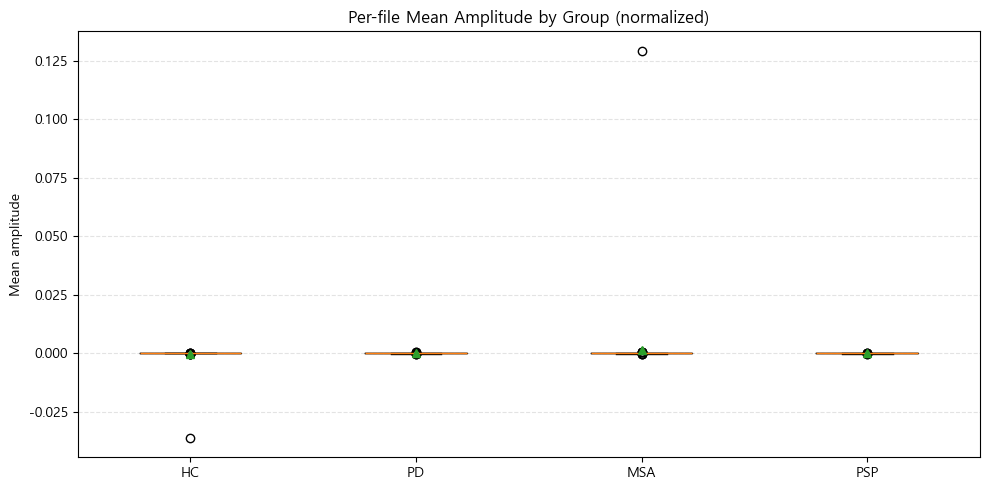

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\1193553091.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


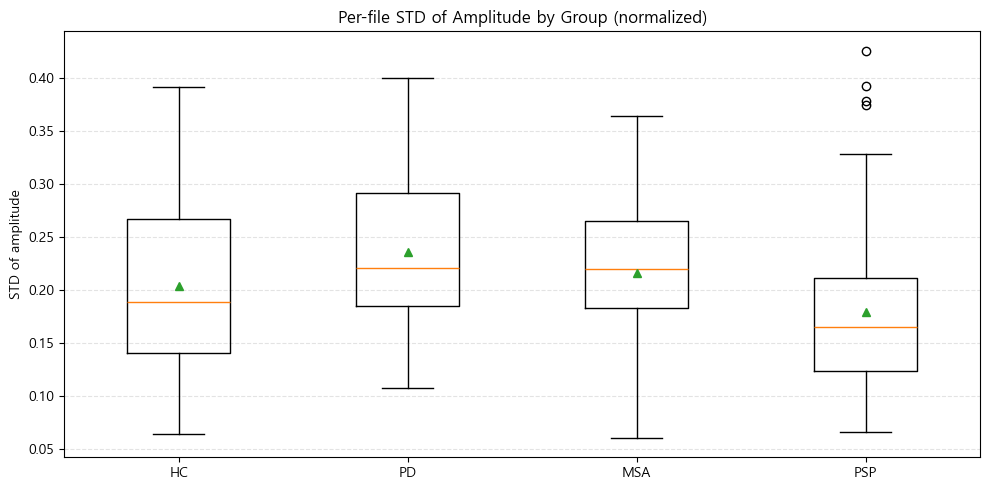

In [32]:
GROUPS = ("HC", "PD", "MSA", "PSP")
DEFAULT_DATA_DIR = r"C:\Users\user\Desktop\parkinsons\DATA\records"  # 경로 수정 가능

# ---------- 파일 탐색 ----------
def find_clean_files(data_dir: str) -> Tuple[List[Path], List[str]]:
    root = Path(data_dir)
    if not root.is_dir():
        raise FileNotFoundError(f"폴더를 찾지 못했습니다: {data_dir}")
    rx = re.compile(r"^(HC|PD|MSA|PSP).*?_clean.*\.wav$", re.IGNORECASE)
    paths, labels = [], []
    for p in root.rglob("*.wav"):
        m = rx.match(p.name)
        if m:
            lab = m.group(1).upper()
            if lab in GROUPS:
                paths.append(p)
                labels.append(lab)
    if not paths:
        raise SystemExit(
            f"[ERROR] 매칭 파일 0개 — data_dir='{data_dir}'\n"
            " - 예시: HC1a1_clean.wav / PD3i2_clean.wav\n"
            " - 파일명이 HC|PD|MSA|PSP 로 시작하고 '_clean' 포함 필요"
        )
    return paths, labels

# ---------- 로딩 & 통계 ----------
def read_wav_segment(path: Path, seconds: Optional[float]) -> Tuple[np.ndarray, int]:
    """seconds>0이면 앞에서부터 해당 길이만, 아니면 전체 길이(frames=-1) 읽기."""
    info = sf.info(path)
    sr = info.samplerate
    frames = int(sr * seconds) if (seconds is not None and seconds > 0) else -1
    # 핵심 수정: frames=None이 아니라 frames=-1을 전달
    y, _sr = sf.read(path, frames=frames, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)  # 모노화
    return y, sr

def per_file_stats(path: Path, seconds: Optional[float], normalize: bool) -> Tuple[float, float]:
    """파일 단위 평균, 표준편차 반환."""
    y, _sr = read_wav_segment(path, seconds=seconds)
    if normalize:
        m = float(np.max(np.abs(y))) + 1e-9
        if m > 0:
            y = y / m
    return float(np.mean(y)), float(np.std(y))

# ---------- 박스플롯 ----------
def boxplot_by_group(data_map: Dict[str, List[float]],
                     title: str, ylabel: str, out_path: str, dpi: int = 300):
    labels = [g for g in GROUPS if g in data_map and len(data_map[g]) > 0]
    data = [data_map[g] for g in labels]
    if not data:
        raise SystemExit("[ERROR] 박스플롯에 쓸 데이터가 없습니다.")

    plt.figure(figsize=(10, 5))
    plt.boxplot(
        data,
        labels=labels,
        showmeans=True,   # 평균점 표시
        notch=False,
        vert=True
    )
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()

# ---------- 요약 출력 ----------
def print_summary(means_map: Dict[str, List[float]], stds_map: Dict[str, List[float]]):
    def stat(v: List[float]) -> Dict[str, float]:
        a = np.asarray(v, dtype=float)
        return dict(
            n=int(a.size),
            mean=float(a.mean()),
            std=float(a.std()),
            min=float(a.min()),
            q25=float(np.percentile(a, 25)),
            median=float(np.median(a)),
            q75=float(np.percentile(a, 75)),
            max=float(a.max()),
        )
    print("\n=== Summary (per-file means) ===")
    for g in GROUPS:
        if g in means_map and means_map[g]:
            print(f"{g}: {stat(means_map[g])}")
    print("\n=== Summary (per-file stds) ===")
    for g in GROUPS:
        if g in stds_map and stds_map[g]:
            print(f"{g}: {stat(stds_map[g])}")

# ---------- 메인 ----------
def main():
    ap = argparse.ArgumentParser(description="그룹별 파일 평균/표준편차 Boxplot")
    ap.add_argument("--data_dir", default=DEFAULT_DATA_DIR, help="데이터 루트 폴더")
    ap.add_argument("--seconds", type=float, default=0.0,
                    help="앞에서부터 사용할 초(<=0이면 전체 길이)")
    ap.add_argument("--normalize", type=str, default="true",
                    help="정규화 사용 여부(true/false), 기본 true")
    ap.add_argument("--out_prefix", default="group_amp", help="저장파일 접두사")
    ap.add_argument("--dpi", type=int, default=300, help="저장 DPI")
    args, _ = ap.parse_known_args()

    seconds = None if args.seconds <= 0 else args.seconds
    normalize = str(args.normalize).lower() in ("1", "true", "t", "yes", "y")

    paths, labels = find_clean_files(args.data_dir)

    means_map: Dict[str, List[float]] = defaultdict(list)
    stds_map: Dict[str, List[float]] = defaultdict(list)

    for p, g in zip(paths, labels):
        mu, sd = per_file_stats(p, seconds=seconds, normalize=normalize)
        means_map[g].append(mu)
        stds_map[g].append(sd)

    print_summary(means_map, stds_map)

    # Boxplots
    boxplot_by_group(
        means_map,
        title=f"Per-file Mean Amplitude by Group ({'normalized' if normalize else 'raw'})",
        ylabel="Mean amplitude",
        out_path=f"{args.out_prefix}_mean_box.png",
        dpi=args.dpi,
    )

    boxplot_by_group(
        stds_map,
        title=f"Per-file STD of Amplitude by Group ({'normalized' if normalize else 'raw'})",
        ylabel="STD of amplitude",
        out_path=f"{args.out_prefix}_std_box.png",
        dpi=args.dpi,
    )

if __name__ == "__main__":
    main()

[OK] CSV 저장: group_feats_perfile_features.csv
group
HC     88
MSA    84
PD     93
PSP    72
dtype: int64


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


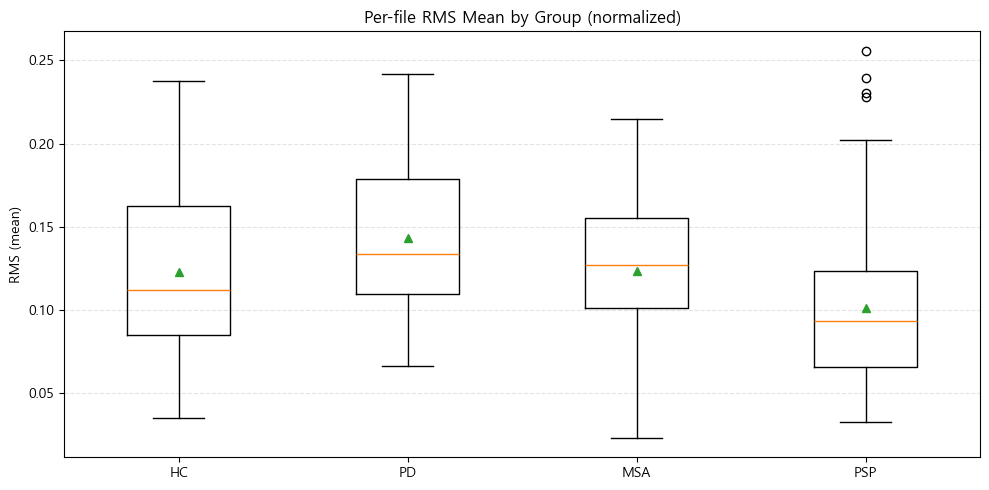

[Kruskal] rms_mean: H=34.264, p=1.743e-07


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


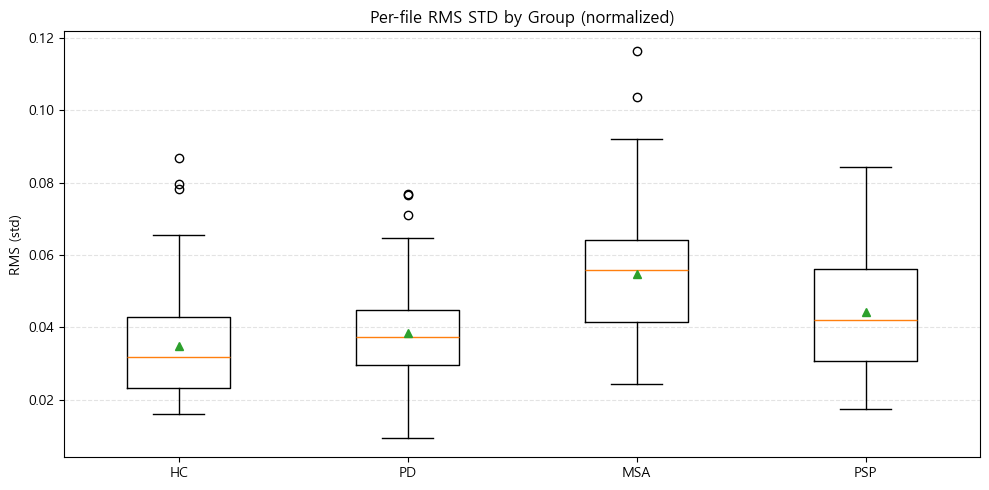

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


[Kruskal] rms_std: H=69.341, p=5.908e-15


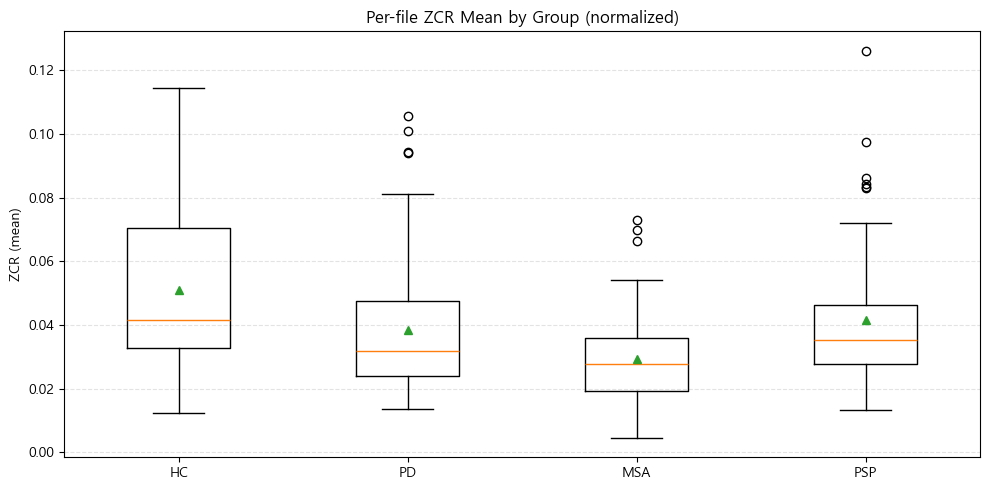

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


[Kruskal] zcr_mean: H=45.387, p=7.657e-10


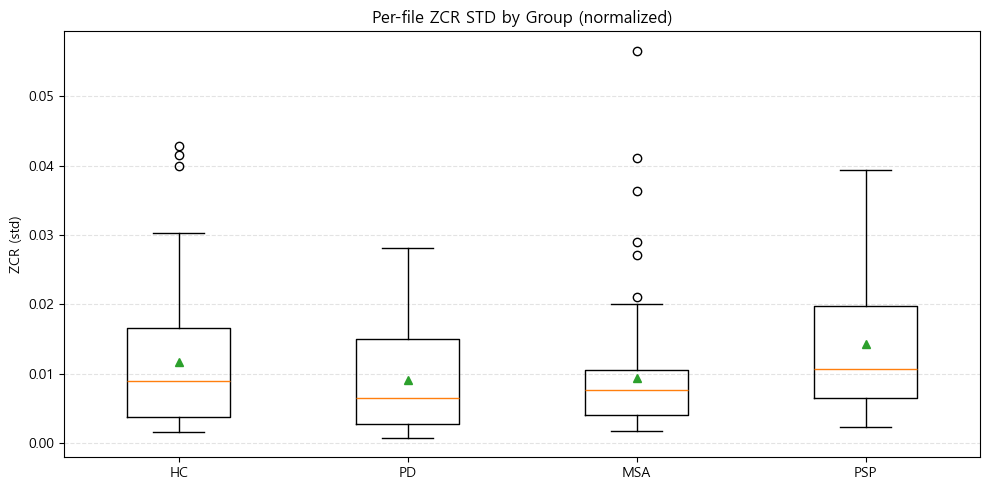

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


[Kruskal] zcr_std: H=17.303, p=0.0006124


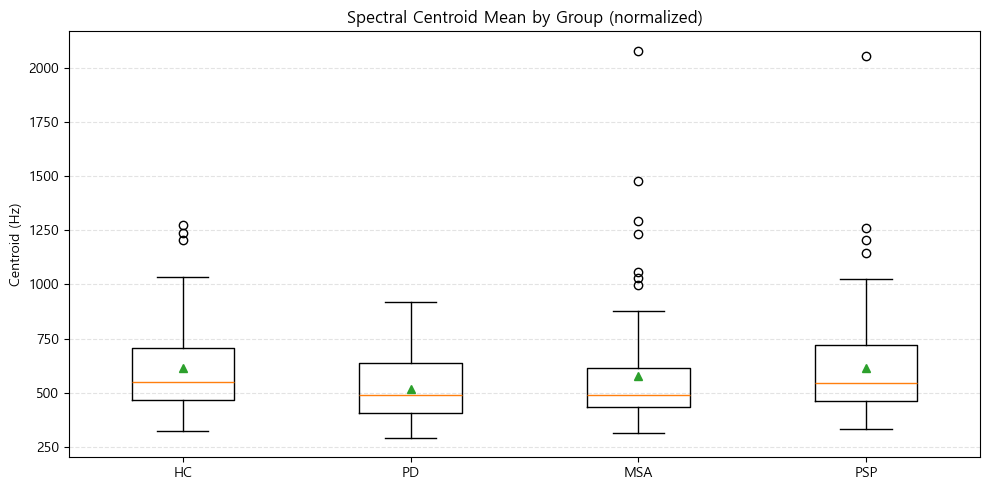

[Kruskal] sc_mean: H=13.922, p=0.003013


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


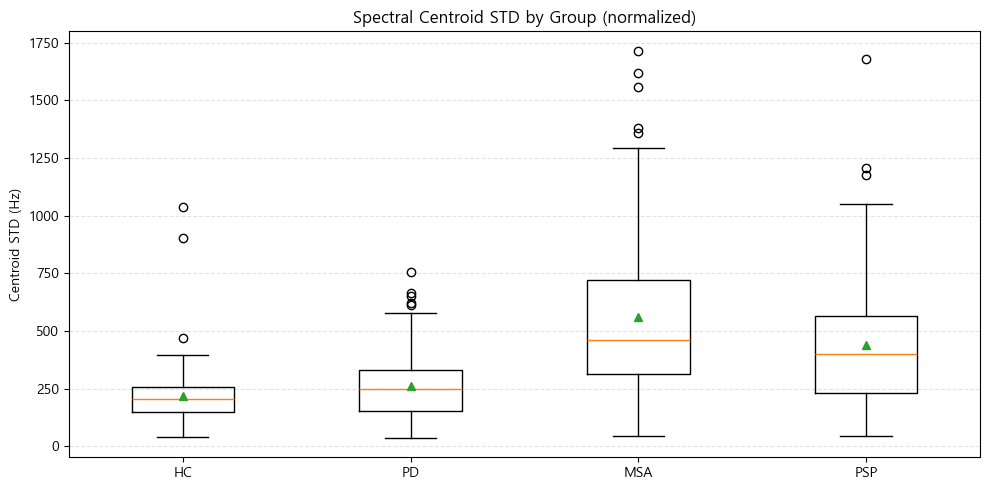

[Kruskal] sc_std: H=89.384, p=2.97e-19


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


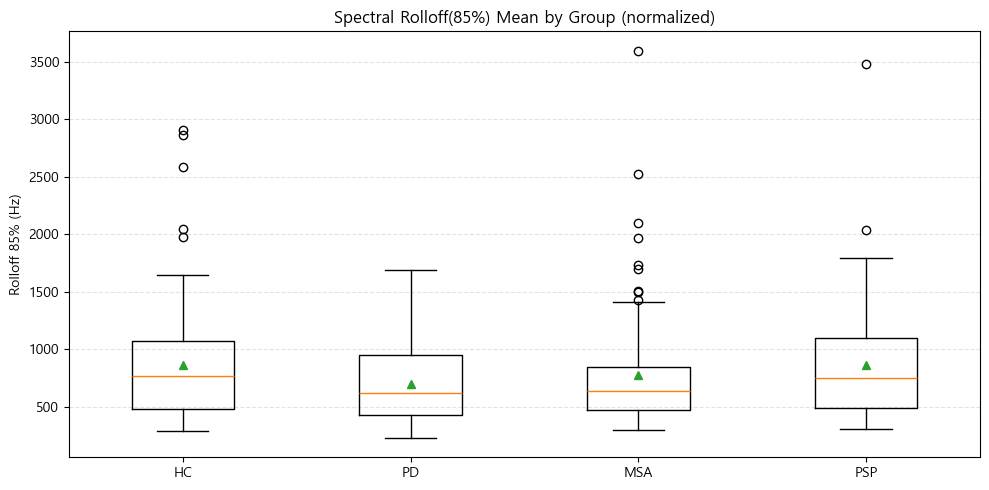

[Kruskal] ro_mean: H=7.272, p=0.06372


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11552\4139141652.py:121: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, showmeans=True)


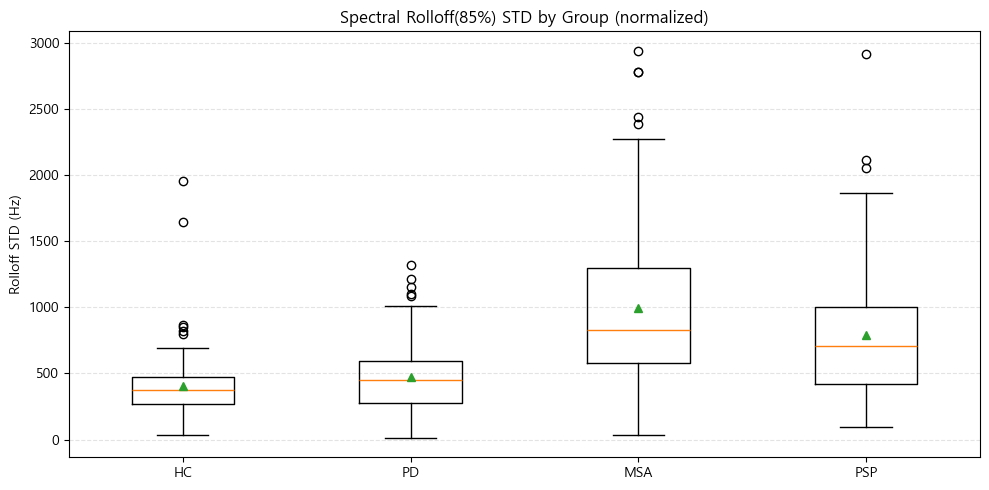

[Kruskal] ro_std: H=85.931, p=1.638e-18


In [33]:
try:
    from scipy.stats import kruskal
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

GROUPS = ("HC", "PD", "MSA", "PSP")
DEFAULT_DATA_DIR = r"C:\Users\user\Desktop\parkinsons\DATA\records"

# -------------------- utils: file scan --------------------
def find_clean_files(data_dir: str) -> Tuple[List[Path], List[str]]:
    root = Path(data_dir)
    if not root.is_dir():
        raise FileNotFoundError(f"폴더를 찾지 못했습니다: {data_dir}")
    rx = re.compile(r"^(HC|PD|MSA|PSP).*?_clean.*\.wav$", re.IGNORECASE)
    paths, labels = [], []
    for p in root.rglob("*.wav"):
        m = rx.match(p.name)
        if m:
            lab = m.group(1).upper()
            if lab in GROUPS:
                paths.append(p); labels.append(lab)
    if not paths:
        raise SystemExit("[ERROR] 매칭 파일 0개 — 파일명이 HC|PD|MSA|PSP로 시작하고 '_clean' 포함 필요")
    return paths, labels

# -------------------- audio helpers --------------------
def read_wav(path: Path) -> Tuple[np.ndarray, int]:
    y, sr = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    return y, sr

def resample_linear(y: np.ndarray, sr_from: int, sr_to: int) -> np.ndarray:
    if sr_from == sr_to:
        return y
    n_new = int(round(len(y) * (sr_to / sr_from)))
    x_old = np.linspace(0.0, 1.0, num=len(y), endpoint=False)
    x_new = np.linspace(0.0, 1.0, num=max(1, n_new), endpoint=False)
    return np.interp(x_new, x_old, y).astype(np.float32)

def frame_signal(y: np.ndarray, sr: int, win_ms=25.0, hop_ms=10.0, win_fn=np.hamming) -> np.ndarray:
    win = int(round(sr * win_ms / 1000.0))
    hop = int(round(sr * hop_ms / 1000.0))
    if win < 1: win = 1
    if hop < 1: hop = 1
    n_frames = 1 + max(0, (len(y) - win) // hop)
    if n_frames < 1:
        return y.reshape(1, -1)
    frames = np.stack([y[i*hop:i*hop+win] for i in range(n_frames)], axis=0)
    if win_fn is not None:
        w = win_fn(win).astype(np.float32)
        frames = frames * w[None, :]
    return frames

# -------------------- features per file --------------------
def zcr(frames: np.ndarray) -> np.ndarray:
    sgn = np.sign(frames)
    sgn[sgn == 0] = 1
    return (np.diff(sgn, axis=1) != 0).mean(axis=1)

def rms(frames: np.ndarray) -> np.ndarray:
    return np.sqrt((frames**2).mean(axis=1))

def spectral_centroid_and_rolloff(frames: np.ndarray, sr: int, roll_percent=0.85) -> Tuple[np.ndarray, np.ndarray]:
    # Zero-pad to power of 2 for speed
    n = frames.shape[1]
    nfft = 1 << (n-1).bit_length()
    spec = np.fft.rfft(frames, n=nfft, axis=1)
    mag = np.abs(spec) + 1e-12
    freqs = np.fft.rfftfreq(nfft, d=1.0/sr)

    # centroid
    centroid = (mag * freqs[None, :]).sum(axis=1) / mag.sum(axis=1)

    # rolloff
    cumsum = np.cumsum(mag, axis=1)
    thresh = roll_percent * mag.sum(axis=1, keepdims=True)
    idx = (cumsum >= thresh).argmax(axis=1)
    rolloff = freqs[idx]
    return centroid.astype(float), rolloff.astype(float)

def per_file_feature_summary(path: Path, seconds: Optional[float], target_sr: int,
                             normalize: bool) -> Dict[str, float]:
    y, sr = read_wav(path)
    # 앞에서 seconds초만 사용 (<=0 또는 None이면 전체)
    if seconds is not None and seconds > 0:
        y = y[:int(sr*seconds)]
    # 정규화(원한다면 off 가능)
    if normalize:
        m = float(np.max(np.abs(y))) + 1e-9
        y = y / m
    # 리샘플 통일
    y = resample_linear(y, sr_from=sr, sr_to=target_sr)
    # 프레이밍
    F = frame_signal(y, target_sr, win_ms=25, hop_ms=10, win_fn=np.hamming)

    feat = {}

    r = rms(F)
    feat["rms_mean"] = float(np.mean(r)); feat["rms_std"] = float(np.std(r))

    z = zcr(F)
    feat["zcr_mean"] = float(np.mean(z)); feat["zcr_std"] = float(np.std(z))

    sc, ro = spectral_centroid_and_rolloff(F, sr=target_sr, roll_percent=0.85)
    feat["sc_mean"] = float(np.mean(sc));  feat["sc_std"]  = float(np.std(sc))
    feat["ro_mean"] = float(np.mean(ro));  feat["ro_std"]  = float(np.std(ro))
    return feat

# -------------------- plotting & stats --------------------
def box_or_violin(df: pd.DataFrame, col: str, title: str, ylabel: str,
                  out_path: str, kind: str = "box", dpi: int = 300):
    groups = [g for g in GROUPS if g in df["group"].unique()]
    data = [df.loc[df["group"] == g, col].values for g in groups]
    plt.figure(figsize=(10, 5))
    if kind == "violin":
        parts = plt.violinplot(data, showmeans=True, showmedians=True)
        plt.xticks(range(1, len(groups)+1), groups)
    else:
        plt.boxplot(data, labels=groups, showmeans=True)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()

def kruskal_report(df: pd.DataFrame, col: str) -> Optional[Tuple[float, float]]:
    if not HAS_SCIPY:
        print(f"[INFO] scipy가 없어 Kruskal–Wallis를 건너뜁니다: {col}")
        return None
    groups = [df.loc[df["group"] == g, col].values for g in GROUPS if g in df["group"].unique()]
    if len(groups) < 2: 
        print(f"[WARN] 그룹이 2개 미만: {col}")
        return None
    stat, p = kruskal(*groups)
    print(f"[Kruskal] {col}: H={stat:.3f}, p={p:.4g}")
    return stat, p

# -------------------- main --------------------
def main():
    ap = argparse.ArgumentParser(description="그룹별 음성 프레임 특징 박스플롯 + 검정")
    ap.add_argument("--data_dir", default=DEFAULT_DATA_DIR)
    ap.add_argument("--seconds", type=float, default=0.0, help="앞에서 사용할 초(<=0이면 전체)")
    ap.add_argument("--normalize", type=str, default="true", help="정규화 사용(true/false)")
    ap.add_argument("--sr", type=int, default=16000, help="리샘플 샘플레이트")
    ap.add_argument("--kind", default="box", choices=["box", "violin"], help="그래프 종류")
    ap.add_argument("--out_prefix", default="group_feats", help="출력파일 접두사")
    ap.add_argument("--dpi", type=int, default=300)
    args, _ = ap.parse_known_args()

    seconds = None if args.seconds <= 0 else args.seconds
    normalize = str(args.normalize).lower() in ("1", "true", "t", "yes", "y")

    paths, labels = find_clean_files(args.data_dir)

    rows = []
    for p, g in zip(paths, labels):
        feat = per_file_feature_summary(p, seconds=seconds, target_sr=args.sr, normalize=normalize)
        feat["group"] = g
        feat["file"] = str(p)
        rows.append(feat)

    df = pd.DataFrame(rows)
    df.to_csv(f"{args.out_prefix}_perfile_features.csv", index=False)
    print(f"[OK] CSV 저장: {args.out_prefix}_perfile_features.csv")
    print(df.groupby("group").size())

    # 그리기 + 검정
    targets = [
        ("rms_mean", "Per-file RMS Mean", "RMS (mean)"),
        ("rms_std",  "Per-file RMS STD",  "RMS (std)"),
        ("zcr_mean", "Per-file ZCR Mean", "ZCR (mean)"),
        ("zcr_std",  "Per-file ZCR STD",  "ZCR (std)"),
        ("sc_mean",  "Spectral Centroid Mean", "Centroid (Hz)"),
        ("sc_std",   "Spectral Centroid STD",  "Centroid STD (Hz)"),
        ("ro_mean",  "Spectral Rolloff(85%) Mean", "Rolloff 85% (Hz)"),
        ("ro_std",   "Spectral Rolloff(85%) STD",  "Rolloff STD (Hz)"),
    ]

    for col, title, ylabel in targets:
        box_or_violin(
            df, col,
            f"{title} by Group ({'normalized' if normalize else 'raw'})",
            ylabel,
            out_path=f"{args.out_prefix}_{col}_{args.kind}.png",
            kind=args.kind,
            dpi=args.dpi
        )
        kruskal_report(df, col)

if __name__ == "__main__":
    main()

In [34]:
try:
    from scipy.stats import kruskal, mannwhitneyu
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False

# 데이터 경로(윈도우는 raw string r"..." 권장)
DATA_DIR = r"C:\Users\user\Desktop\parkinsons\DATA\records"

GROUPS = ("HC", "PD", "MSA", "PSP")

def find_clean_files(data_dir: str) -> Tuple[List[Path], List[str]]:
    root = Path(data_dir)
    if not root.is_dir():
        raise FileNotFoundError(f"폴더를 찾지 못했습니다: {data_dir}")
    rx = re.compile(r"^(HC|PD|MSA|PSP).*?_clean.*\.wav$", re.IGNORECASE)
    paths, labels = [], []
    for p in root.rglob("*.wav"):
        m = rx.match(p.name)
        if m:
            lab = m.group(1).upper()
            if lab in GROUPS:
                paths.append(p); labels.append(lab)
    if not paths:
        raise SystemExit("[ERROR] 매칭 파일 0개 — 파일명이 HC|PD|MSA|PSP로 시작하고 '_clean' 포함 필요")
    return paths, labels

def read_wav(path: Path) -> Tuple[np.ndarray, int]:
    y, sr = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim == 2:  # stereo -> mono
        y = y.mean(axis=1)
    return y, sr

def resample_linear(y: np.ndarray, sr_from: int, sr_to: int) -> np.ndarray:
    if sr_from == sr_to:
        return y
    n_new = int(round(len(y) * (sr_to / sr_from)))
    x_old = np.linspace(0.0, 1.0, num=len(y), endpoint=False)
    x_new = np.linspace(0.0, 1.0, num=max(1, n_new), endpoint=False)
    return np.interp(x_new, x_old, y).astype(np.float32)

def frame_signal(y: np.ndarray, sr: int, win_ms=25.0, hop_ms=10.0, win_fn=np.hamming) -> np.ndarray:
    win = max(1, int(round(sr * win_ms / 1000.0)))
    hop = max(1, int(round(sr * hop_ms / 1000.0)))
    n_frames = 1 + max(0, (len(y) - win) // hop)
    if n_frames < 1:
        return y.reshape(1, -1)
    frames = np.stack([y[i*hop:i*hop+win] for i in range(n_frames)], axis=0)
    if win_fn is not None:
        frames = frames * win_fn(win).astype(np.float32)[None, :]
    return frames

def zcr(frames: np.ndarray) -> np.ndarray:
    s = np.sign(frames); s[s == 0] = 1
    return (np.diff(s, axis=1) != 0).mean(axis=1)

def rms(frames: np.ndarray) -> np.ndarray:
    return np.sqrt((frames**2).mean(axis=1))

def spectral_centroid_and_rolloff(frames: np.ndarray, sr: int, roll_percent=0.85):
    n = frames.shape[1]
    nfft = 1 << (n-1).bit_length()
    spec = np.fft.rfft(frames, n=nfft, axis=1)
    mag = np.abs(spec) + 1e-12
    freqs = np.fft.rfftfreq(nfft, d=1.0/sr)
    centroid = (mag * freqs[None, :]).sum(axis=1) / mag.sum(axis=1)
    cumsum = np.cumsum(mag, axis=1)
    thresh = roll_percent * mag.sum(axis=1, keepdims=True)
    idx = (cumsum >= thresh).argmax(axis=1)
    rolloff = freqs[idx]
    return centroid.astype(float), rolloff.astype(float)

def group_color(group: str):
    cmap = plt.get_cmap("tab20")
    base_idx = {"HC": 0, "PD": 2, "MSA": 4, "PSP": 6}[group.upper()]
    return cmap(base_idx)

In [37]:
# === 셀 3: per-file 특징 추출 ===
def per_file_feature_summary(path: Path, seconds: Optional[float], target_sr: int = 16000,
                             normalize: bool = True, voiced_only: bool = False) -> Dict[str, float]:
    y, sr = read_wav(path)
    if seconds and seconds > 0:
        y = y[:int(sr*seconds)]
    if normalize:
        m = float(np.max(np.abs(y))) + 1e-9
        y = y / m
    y = resample_linear(y, sr_from=sr, sr_to=target_sr)
    F = frame_signal(y, target_sr, win_ms=25, hop_ms=10, win_fn=np.hamming)

    if voiced_only:
        r = rms(F)
        thr = np.median(r) * 0.6
        mask = r > thr
        if mask.any():
            F = F[mask]

    r = rms(F); z = zcr(F); sc, ro = spectral_centroid_and_rolloff(F, sr=target_sr, roll_percent=0.85)
    return {
        "rms_mean": float(np.mean(r)),  "rms_std": float(np.std(r)),
        "zcr_mean": float(np.mean(z)),  "zcr_std": float(np.std(z)),
        "sc_mean":  float(np.mean(sc)), "sc_std":  float(np.std(sc)),
        "ro_mean":  float(np.mean(ro)), "ro_std":  float(np.std(ro)),
    }

# 추출 실행
paths, labels = find_clean_files(DATA_DIR)
rows = []
for p, g in zip(paths, labels):
    feat = per_file_feature_summary(p, seconds=None, target_sr=16000, normalize=True, voiced_only=False)
    feat["group"] = g; feat["file"] = str(p)
    rows.append(feat)

df_feats = pd.DataFrame(rows)
display(df_feats.head())
print(df_feats.groupby("group").size())


,rms_mean,rms_std,zcr_mean,zcr_std,sc_mean,sc_std,ro_mean,ro_std,group,file
0,0.061115,0.023365,0.070354,0.030287,746.780422,56.952905,1142.573949,92.231604,HC,C:\Users\user\Desktop\parkinsons\DATA\records\...
1,0.073610,0.025679,0.028228,0.013681,577.772463,248.310009,990.448880,447.226625,HC,C:\Users\user\Desktop\parkinsons\DATA\records\...
2,0.105376,0.044507,0.038154,0.003234,414.548085,206.206500,373.501904,361.864545,HC,C:\Users\user\Desktop\parkinsons\DATA\records\...
3,0.084976,0.022394,0.037207,0.006311,447.517220,192.834423,492.734554,345.807818,HC,C:\Users\user\Desktop\parkinsons\DATA\records\...
4,0.108811,0.023410,0.060095,0.013510,531.584950,47.072614,830.302895,91.869524,HC,C:\Users\user\Desktop\parkinsons\DATA\records\...


group
HC     88
MSA    84
PD     93
PSP    72
dtype: int64


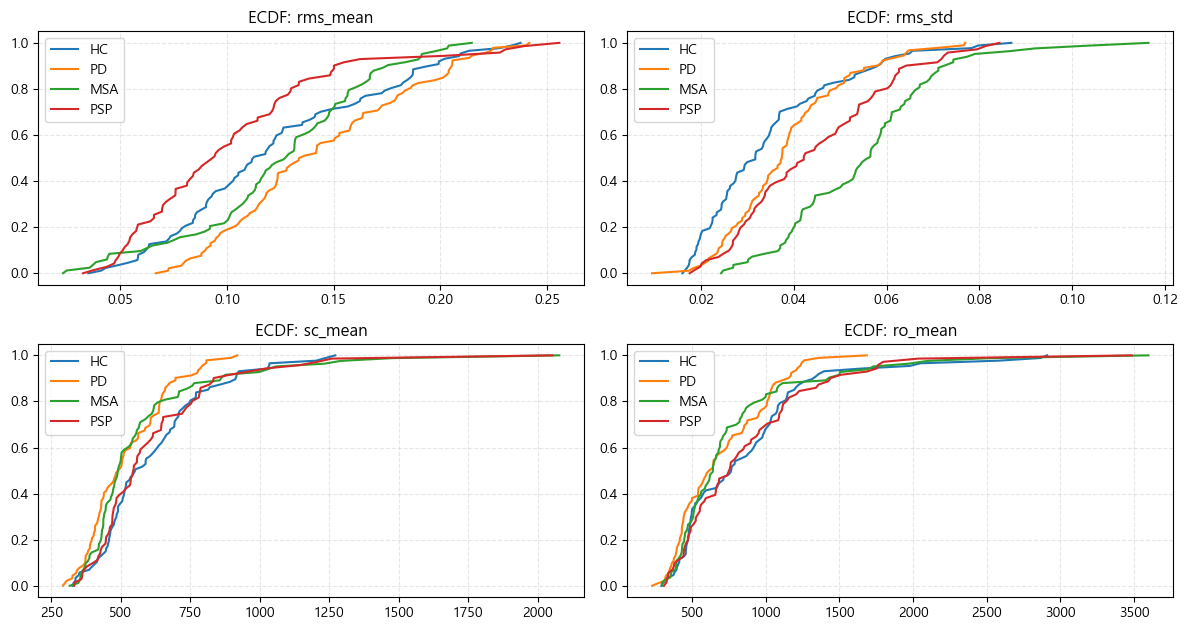

In [ ]:
# df_feats: 이전에 만든 per-file 특징 DataFrame (file, group, rms_mean, ...)
# ECDF(누적분포)패널 - 그룹 간 분포 차이를 선명하게

def plot_ecdf_panels(df, cols=("rms_mean","rms_std","zcr_mean","zcr_std")):
    groups = ["HC","PD","MSA","PSP"]
    cmap = plt.get_cmap("tab20")
    gcol = {"HC":cmap(0),"PD":cmap(2),"MSA":cmap(4),"PSP":cmap(6)}
    R = int(np.ceil(len(cols)/2)); C = 2
    fig, axes = plt.subplots(R, C, figsize=(12, 3.2*R), sharex=False, sharey=False)
    axes = axes.ravel()
    for ax, col in zip(axes, cols):
        for g in groups:
            v = df.loc[df.group==g, col].values
            if len(v)==0: continue
            v = np.sort(v)
            y = np.linspace(0,1,len(v),endpoint=True)
            ax.plot(v, y, label=g, color=gcol[g])
        ax.set_title(f"ECDF: {col}")
        ax.grid(True, ls="--", alpha=0.3)
        ax.legend()
    for k in range(len(cols), len(axes)):
        axes[k].axis("off")
    plt.tight_layout()
    plt.show()

plot_ecdf_panels(df_feats, cols=["rms_mean","rms_std","sc_mean","ro_mean"])


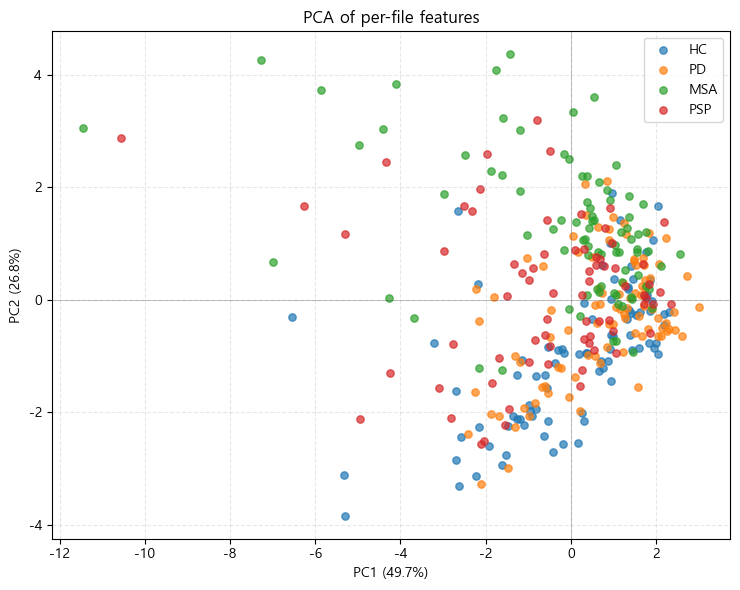

In [ ]:
# PCA 2D 스캐터 - 특징 묶음의 분리도 한눈에

def pca_2d_scatter(df, feat_cols=None):
    if feat_cols is None:
        feat_cols = ["rms_mean","rms_std","zcr_mean","zcr_std","sc_mean","sc_std","ro_mean","ro_std"]
    X = df[feat_cols].to_numpy(dtype=float)
    # 표준화(평균0, 표준편차1)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-9
    Z = (X - mu) / sd

    # SVD로 PCA
    U, S, Vt = np.linalg.svd(Z, full_matrices=False)
    Z2 = U[:, :2] * S[:2]  # 주성분 2D
    evr = (S**2) / (Z.shape[0]-1)
    evr = evr / evr.sum()

    cmap = plt.get_cmap("tab20")
    gcol = {"HC":cmap(0),"PD":cmap(2),"MSA":cmap(4),"PSP":cmap(6)}

    plt.figure(figsize=(7.5,6))
    for g in ["HC","PD","MSA","PSP"]:
        idx = (df["group"].values==g)
        plt.scatter(Z2[idx,0], Z2[idx,1], s=28, alpha=0.7, label=g, color=gcol[g])
    plt.axhline(0, color="k", lw=0.5, alpha=0.3); plt.axvline(0, color="k", lw=0.5, alpha=0.3)
    plt.xlabel(f"PC1 ({evr[0]*100:.1f}%)"); plt.ylabel(f"PC2 ({evr[1]*100:.1f}%)")
    plt.title("PCA of per-file features")
    plt.legend(); plt.grid(True, ls="--", alpha=0.3); plt.tight_layout(); plt.show()

pca_2d_scatter(df_feats)

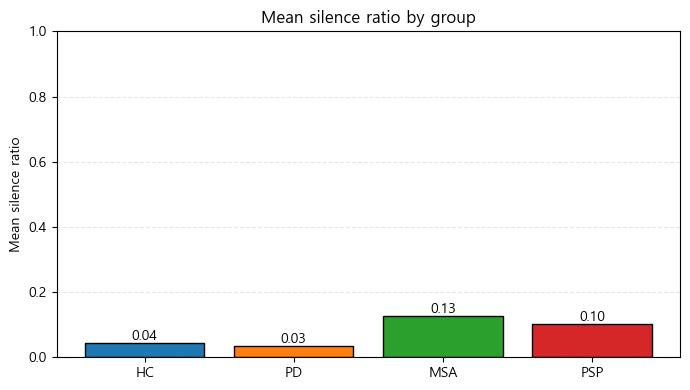

In [42]:
# 침묵 비율(bar) - 발화/무성 구간 비중 비교

def silence_ratio_per_file(y, sr, win_ms=25, hop_ms=10):
    # 프레이밍 파라미터
    win = int(round(sr * win_ms / 1000.0))
    hop = int(round(sr * hop_ms / 1000.0))
    if win < 1:
        win = 1
    if hop < 1:
        hop = 1

    # 프레임 개수
    n = 1 + max(0, (len(y) - win) // hop)
    if n < 1:
        return 0.0

    # 프레임 RMS
    r = np.empty(n, dtype=np.float32)
    for i in range(n):
        seg = y[i * hop : i * hop + win]
        r[i] = np.sqrt((seg**2).mean())

    # 간단 VAD 임계값(중앙값 기반)
    thr = np.median(r) * 0.6
    return float((r <= thr).mean())  # 무성(침묵) 비율

def plot_silence_ratio_bar(data_dir, sample_sr=16000):
    paths, labels = find_clean_files(data_dir)
    ratios = {"HC":[], "PD":[], "MSA":[], "PSP":[]}
    for p, g in zip(paths, labels):
        y, sr = read_wav(p)
        # 정규화 & 리샘플
        m = np.max(np.abs(y))+1e-9; y = y/m
        y = resample_linear(y, sr_from=sr, sr_to=sample_sr)
        ratios[g].append(silence_ratio_per_file(y, sample_sr))
    groups = ["HC","PD","MSA","PSP"]
    vals = [np.mean(ratios[g]) if len(ratios[g])>0 else 0 for g in groups]

    cmap = plt.get_cmap("tab20")
    colors = [cmap(0),cmap(2),cmap(4),cmap(6)]
    plt.figure(figsize=(7,4))
    bars = plt.bar(groups, vals, color=colors, edgecolor="black")
    for b,v in zip(bars, vals):
        plt.text(b.get_x()+b.get_width()/2, v, f"{v:.2f}", ha="center", va="bottom")
    plt.ylabel("Mean silence ratio"); plt.title("Mean silence ratio by group")
    plt.ylim(0,1); plt.grid(axis="y", ls="--", alpha=0.3); plt.tight_layout(); plt.show()

plot_silence_ratio_bar(DATA_DIR)